In [43]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# to avoid a cuBLAS error, per https://stackoverflow.com/questions/43990046/tensorflow-blas-gemm-launch-failed
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Very basic TensorFlow to do automatic differentiation

In [3]:
x = tf.Variable(0.)
with tf.GradientTape() as tape:
    y = 2 * x + 3
grad_of_y_wrt_x = tape.gradient(y, x)
grad_of_y_wrt_x

<tf.Tensor: shape=(), dtype=float32, numpy=2.0>

Ok, so we showed above that the derivative of 2x+3 is 2. Cool. This is a single variable/single dimension.

And I should remember explicitly that gradient(y, x), pronounced 'gradient of y with respect to x', truly means 'how does y change when x changes?'

And with two dimensions, so where x is a matrix, or more generally, a tensor. 

In [4]:
x = tf.Variable(tf.random.uniform((2,2)))  # a 2x2 matrix, aka a 2x2 tensor
with tf.GradientTape() as tape:
    y = 2 * x + 3
tape.gradient(y, x)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[2., 2.],
       [2., 2.]], dtype=float32)>

And with a list of variables that matches here a single layer neural network.

In [5]:
tf.zeros((2,))

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0., 0.], dtype=float32)>

In [6]:
W = tf.Variable(tf.random.uniform((2, 2)))
b = tf.Variable(tf.zeros((2,)))
x = tf.random.uniform((2, 2))
with tf.GradientTape() as tape:
    y = tf.matmul(W, x) + b
tape.gradient(y, [W, b]) # how does y change when W and b change?

[<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[0.9384725 , 0.65181494],
        [0.9384725 , 0.65181494]], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([2., 2.], dtype=float32)>]

The return value above is a list two tensors, with the same shape as W and b respectively. So the more specific answer to the question of 'how does y change when W and b change' I think shows how... y changes when W changes (which is a 2x2 matrix) and how y changes when b changes, which is a vector of length 2?

# Implementing a very simple network in straight TensorFlow

In [7]:
class NaiveDense:
    
    def __init__(self, input_size, output_size, activation):
        self.activation = activation
        
        w_shape = (input_size, output_size)
        w_initial_value = tf.random.uniform(w_shape, minval=0, maxval=1e-1)
        self.W = tf.Variable(w_initial_value)
        
        b_shape = (output_size,)
        b_initial_value = tf.zeros(b_shape)
        self.b = tf.Variable(b_initial_value)
        
    def __call__(self, inputs):
        return self.activation(tf.matmul(inputs, self.W) + self.b)
    
    @property
    def weights(self):
        return [self.W, self.b]

In [8]:
class NaiveSequential:
    
    def __init__(self, layers):
        self.layers = layers
        
    def __call__(self, inputs):
        x = inputs
        for layer in self.layers:
            x = layer(x)
        return x
    
    @property
    def weights(self):
        weights = []
        for layer in self.layers:
            weights += layer.weights
        return weights

In [9]:
model = NaiveSequential([
    NaiveDense(input_size=28 * 28, output_size=512, activation=tf.nn.relu),
    NaiveDense(input_size=512, output_size=10, activation=tf.nn.softmax)
])
assert len(model.weights) == 4

In [10]:
model.weights

[<tf.Variable 'Variable:0' shape=(784, 512) dtype=float32, numpy=
 array([[0.00020006, 0.03763029, 0.04962463, ..., 0.0475448 , 0.05623397,
         0.09663551],
        [0.00132641, 0.09480002, 0.08463013, ..., 0.08094152, 0.09253608,
         0.00732968],
        [0.05128513, 0.0646975 , 0.06485201, ..., 0.08848702, 0.03092421,
         0.05387162],
        ...,
        [0.07500374, 0.0538681 , 0.07523077, ..., 0.08709895, 0.09435351,
         0.00818778],
        [0.09089661, 0.08442718, 0.08100881, ..., 0.05257652, 0.01122145,
         0.07260058],
        [0.0132813 , 0.09566064, 0.00056422, ..., 0.04370818, 0.08751756,
         0.0733248 ]], dtype=float32)>,
 <tf.Variable 'Variable:0' shape=(512,) dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0

In [11]:
class BatchGenerator:
    
    def __init__(self, images, labels, batch_size=128):
        self.index = 0
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        
    def next(self):
        images = self.images[self.index : self.index + self.batch_size]
        labels = self.labels[self.index : self.index + self.batch_size]
        self.index += self.batch_size
        return images, labels

In [12]:
def one_training_step(model, images_batch, labels_batch):
    with tf.GradientTape() as tape:
        predictions = model(images_batch)
        per_sample_losses = tf.keras.losses.sparse_categorical_crossentropy(labels_batch, predictions)
        average_loss = tf.reduce_mean(per_sample_losses)
    
    gradients = tape.gradient(average_loss, model.weights) # how does the average loss change when the weights change?
    update_weights_naive(gradients, model.weights)
    return average_loss

In [13]:
learning_rate = 1e-3

def update_weights_naive(gradients, weights):
    for g, w in zip(gradients, weights):
        w.assign_sub(w * learning_rate) # assign_sub is the TF equivalent of -=
        
from tensorflow.keras import optimizers
optimizer = optimizers.SGD(learning_rate=1e-3)
def update_weights_via_Keras(gradients, weights):
    optimizer.apply_gradients(zip(gradients, weights))

In [14]:
# implement an epoch of training - i.e., use all of the data, in batches 
def fit(model, images, labels, epochs, batch_size=128):
    for epoch_counter in range(epochs):
        print(f'Epoch {epoch_counter}')
        batch_generator = BatchGenerator(images, labels)
        for batch_counter in range(len(images) // batch_size):
            images_batch, labels_batch = batch_generator.next()
            loss = one_training_step(model, images_batch, labels_batch)
            if batch_counter % 100 == 0:
                print(f'Loss at batch {batch_counter} is {loss:.2f}')

In [15]:
from tensorflow.keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [16]:
train_images = train_images.reshape((60000, 28 * 28)).astype('float32') / 255
test_images = test_images.reshape((10000, 28 * 28)).astype('float32') / 255
train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((60000, 784), (60000,), (10000, 784), (10000,))

In [17]:
fit(model, train_images, train_labels, epochs=5, batch_size=128)

Epoch 0
Loss at batch 0 is 7.49
Loss at batch 100 is 5.75
Loss at batch 200 is 5.15
Loss at batch 300 is 4.12
Loss at batch 400 is 4.08
Epoch 1
Loss at batch 0 is 3.58
Loss at batch 100 is 3.05
Loss at batch 200 is 2.87
Loss at batch 300 is 2.64
Loss at batch 400 is 2.63
Epoch 2
Loss at batch 0 is 2.56
Loss at batch 100 is 2.43
Loss at batch 200 is 2.39
Loss at batch 300 is 2.36
Loss at batch 400 is 2.36
Epoch 3
Loss at batch 0 is 2.36
Loss at batch 100 is 2.33
Loss at batch 200 is 2.32
Loss at batch 300 is 2.31
Loss at batch 400 is 2.31
Epoch 4
Loss at batch 0 is 2.32
Loss at batch 100 is 2.31
Loss at batch 200 is 2.30
Loss at batch 300 is 2.30
Loss at batch 400 is 2.30


In [18]:
predictions = model(test_images).numpy() # the numpy method converts a TF tensor to a NumPy tensor
predicted_labels = np.argmax(predictions, axis=1)
matches = predicted_labels == test_labels
print(f'accuracy: {matches.average():.2f}')

AttributeError: 'numpy.ndarray' object has no attribute 'average'

In [ ]:
predictions

In [ ]:
np.argmax(predictions, axis=1)[100:125]

In [ ]:
predictions[5]

In [ ]:
len(predicted_labels == 8)

So, it doesn't actually work... 

# Chapter three: raw TensorFlow stuff

In [19]:
x = tf.ones(shape=(2,1))

In [20]:
x

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[1.],
       [1.]], dtype=float32)>

In [21]:
x = tf.random.normal(shape=(3, 1), mean=0., stddev=1.)
x

<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[ 0.19001003],
       [ 0.7287675 ],
       [-0.14747596]], dtype=float32)>

NumPy arrarys are assignable, while TF tensors aren't.

In [24]:
x = np.ones(shape=(2,2))
x

array([[1., 1.],
       [1., 1.]])

In [25]:
x[0, 0] = 0
x

array([[0., 1.],
       [1., 1.]])

In [26]:
x = tf.ones(shape=(2, 2))
x

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[1., 1.],
       [1., 1.]], dtype=float32)>

In [27]:
x[0, 0] = 0

TypeError: 'tensorflow.python.framework.ops.EagerTensor' object does not support item assignment

Instead, we use tf.Variable, which enables us to manage modifiable state in TF.

In [28]:
v = tf.Variable(initial_value=tf.random.normal(shape=(3, 1)))
v

<tf.Variable 'Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[-0.27158242],
       [-1.7815425 ],
       [ 0.2300442 ]], dtype=float32)>

In [34]:
v.assign(tf.ones((3, 1)))

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[1.],
       [1.],
       [1.]], dtype=float32)>

In [35]:
v

<tf.Variable 'Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[1.],
       [1.],
       [1.]], dtype=float32)>

In [36]:
v[2, 0].assign(3.)

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[1.],
       [1.],
       [3.]], dtype=float32)>

In [37]:
input_var = tf.Variable(initial_value=3.)
input_var

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=3.0>

In [38]:
with tf.GradientTape() as tape:
    result = tf.square(input_var)
tape.gradient(result, input_var)

<tf.Tensor: shape=(), dtype=float32, numpy=6.0>

In [39]:
time = tf.Variable(0.)
with tf.GradientTape() as outer_tape:
    with tf.GradientTape() as inner_tape:
        position = 4.9 * time ** 2
    speed = inner_tape.gradient(position, time)
acceleration = outer_tape.gradient(speed, time)

speed, acceleration

(<tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=9.8>)

# A linear classifier in pure TensorFlow

You can use the above - just tensors, variables, tensor operations, and gradients - "to build any machine learning model based on gradient descent". Here's a linear classifier in pure TensorFlow.

Start with some nicely linear-separable synthetic data: two classes of points in a 2D plane.

In [46]:
num_samples_per_class = 1000
negative_samples = np.random.multivariate_normal(mean=[0, 3], cov=[[1, 0.5], [0.5, 1]], size=num_samples_per_class)
positive_samples = np.random.multivariate_normal(mean=[3, 0], cov=[[1, 0.5], [0.5, 1]], size=num_samples_per_class)

negative_samples[0]

array([-0.17187074,  3.46578362])

In [48]:
inputs = np.vstack((negative_samples, positive_samples)).astype(np.float32)
inputs[:10]

array([[-0.17187074,  3.4657836 ],
       [ 1.4929743 ,  3.5204666 ],
       [ 0.16533373,  3.904512  ],
       [ 0.62983274,  2.4056258 ],
       [ 0.9910599 ,  3.577066  ],
       [ 0.6188259 ,  1.9627407 ],
       [-1.2536201 ,  0.806768  ],
       [ 0.545922  ,  2.6858382 ],
       [ 1.7723546 ,  2.6724916 ],
       [ 0.35783532,  2.9286509 ]], dtype=float32)

In [42]:
targets = np.vstack((np.zeros((num_samples_per_class, 1), dtype='float32'),
                     np.ones((num_samples_per_class, 1), dtype='float32')))
targets[:10]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

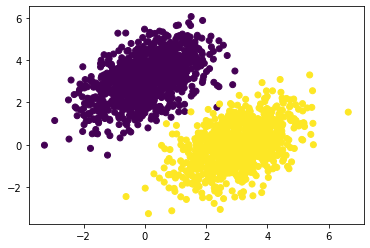

In [44]:
plt.scatter(inputs[:, 0], inputs[:, 1], c=targets[:, 0])

A "linear classifier is an affine transformation - prediction = W dot input + b - trained to minimize the square of the diference between predictions and targets". We can build one that'll separate the blobs.

In [59]:
input_dim = 2 # inputs are 2D points
output_dim = 1 # output is a single score per sample, close to 0 if pred. to be clas 0, close to 1 for class 1

In [60]:
W = tf.Variable(initial_value=tf.random.uniform(shape=(input_dim, output_dim)))
b = tf.Variable(initial_value=tf.zeros(shape=(output_dim,)))

In [61]:
def model(inputs):
    return tf.matmul(inputs, W) + b

In [62]:
def square_loss(targets, predictions):
    per_sample_losses = tf.square(targets - predictions)
    return tf.reduce_mean(per_sample_losses)

In [63]:
learning_rate = 0.1

def training_step(inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        loss = square_loss(predictions, targets)
    grad_loss_wrt_W, grad_loss_wrt_b = tape.gradient(loss, [W, b])
    W.assign_sub(grad_loss_wrt_W * learning_rate)
    b.assign_sub(grad_loss_wrt_b * learning_rate)
    return loss

In [64]:
for step in range(50):
    loss = training_step(inputs, targets)
    print(f'Loss at step {step}: {loss:.4f}')

Loss at step 0: 0.5944
Loss at step 1: 0.0825
Loss at step 2: 0.0743
Loss at step 3: 0.0694
Loss at step 4: 0.0653
Loss at step 5: 0.0617
Loss at step 6: 0.0583
Loss at step 7: 0.0553
Loss at step 8: 0.0525
Loss at step 9: 0.0500
Loss at step 10: 0.0477
Loss at step 11: 0.0456
Loss at step 12: 0.0437
Loss at step 13: 0.0420
Loss at step 14: 0.0404
Loss at step 15: 0.0389
Loss at step 16: 0.0376
Loss at step 17: 0.0365
Loss at step 18: 0.0354
Loss at step 19: 0.0344
Loss at step 20: 0.0335
Loss at step 21: 0.0327
Loss at step 22: 0.0319
Loss at step 23: 0.0313
Loss at step 24: 0.0306
Loss at step 25: 0.0301
Loss at step 26: 0.0296
Loss at step 27: 0.0291
Loss at step 28: 0.0287
Loss at step 29: 0.0283
Loss at step 30: 0.0279
Loss at step 31: 0.0276
Loss at step 32: 0.0273
Loss at step 33: 0.0271
Loss at step 34: 0.0268
Loss at step 35: 0.0266
Loss at step 36: 0.0264
Loss at step 37: 0.0262
Loss at step 38: 0.0261
Loss at step 39: 0.0259
Loss at step 40: 0.0258
Loss at step 41: 0.0256
Lo

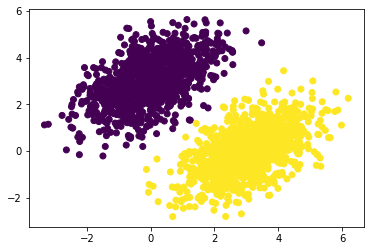

In [65]:
predictions = model(inputs)
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)

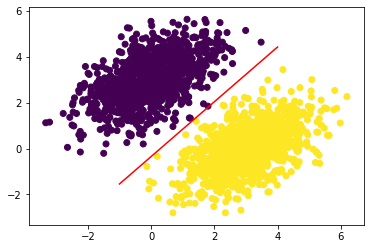

In [66]:
x = np.linspace(-1, 4, 1000)
y = - W[0] / W[1] * x + (0.5 - b) / W[1]
plt.plot(x, y, '-r')
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)